In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import acf, pacf
path = "D:/program/program1/Cargo_forecast/dot_data_all/"
print(os.listdir(path))
rcParams['figure.figsize'] = 16,4

['20181207dot1.xlsx', '20181207_莉娜_点部#1.xlsx', '20181207_莉娜_点部#2.xlsx', '20181207_莉娜_点部#3.xlsx', '20190103_点部取货量_1.xlsx', '20190103_点部取货量_2.xlsx', '20190103_点部派货量_1.xlsx', '20190103_点部派货量_2.xlsx', 'accurate.xlsx', 'comments.txt', 'test.csv', 'test_predict.png']


In [3]:
dot_data_1 = pd.read_excel(path + '20190103_点部取货量_1.xlsx', parse_dates=[1])
dot_data_2 = pd.read_excel(path + '20190103_点部取货量_2.xlsx', parse_dates = [1])

In [4]:
dot_data = pd.concat([dot_data_1,dot_data_2],ignore_index = True)

In [5]:
data = dot_data.copy()
data = data.drop(['num', 'jifei_weight', 'shiji_weight', 'longitude', 'latitude'], axis = 1)

In [6]:
data_ts = data.copy()
data_ts.index = data['order_date']
data_ts.head()

,dot,order_date,order_num
order_date,,,
2017-05-23,13825092291,2017-05-23,1
2017-06-06,15102680258,2017-06-06,1
2017-06-09,ERP客户系统组,2017-06-09,1
2017-04-13,IT采购组,2017-04-13,8
2017-05-03,IT采购组,2017-05-03,4


In [7]:
data_ts.sort_index(ascending = True, inplace = True)
tmp = data_ts['2017-11':]
tmp.head()

,dot,order_date,order_num
order_date,,,
2017-11-01,松江新桥点部,2017-11-01,113
2017-11-01,成都公兴点部,2017-11-01,3
2017-11-01,宁海桃源点部,2017-11-01,61
2017-11-01,海口龙华点部,2017-11-01,5
2017-11-01,温州娄桥点部,2017-11-01,110


In [8]:
data_count = pd.DataFrame(tmp['order_date'].groupby(tmp['dot']).count())
data_count.reset_index(inplace = True)
useful_dot_name = data_count.loc[data_count['order_date'] >= 360, ['dot']]
useful_dot_name.head()

,dot
31,上虞上浦点部
32,上虞东关点部
36,上虞小越点部
38,上虞崧厦点部
58,东丽中心庄点部


In [9]:
result_data = tmp.loc[tmp['dot'].isin(useful_dot_name['dot'])]
result_data.head()

,dot,order_date,order_num
order_date,,,
2017-11-01,宁海桃源点部,2017-11-01,61
2017-11-01,温州娄桥点部,2017-11-01,110
2017-11-01,寮步凫山点部,2017-11-01,16
2017-11-01,惠山玉祁点部,2017-11-01,31
2017-11-01,金陵光华门点部,2017-11-01,8


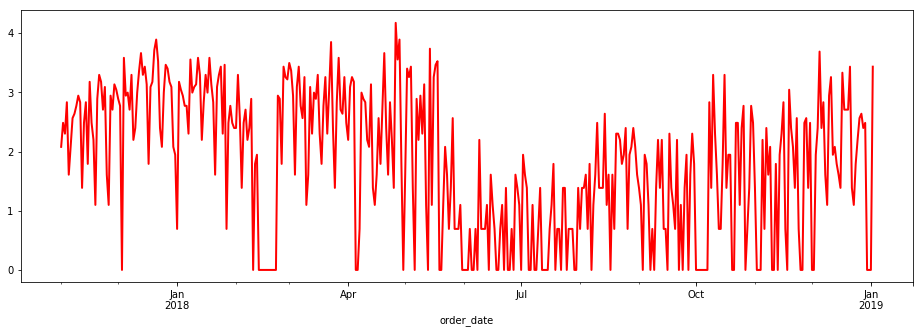

In [111]:
result_ts = result_data.loc[result_data['dot'] == '金陵光华门点部', ['order_num']]
# result_ts_log = np.log(result_ts)
result_ts_log.plot(figsize = (16,5), color = 'r', linewidth=2)

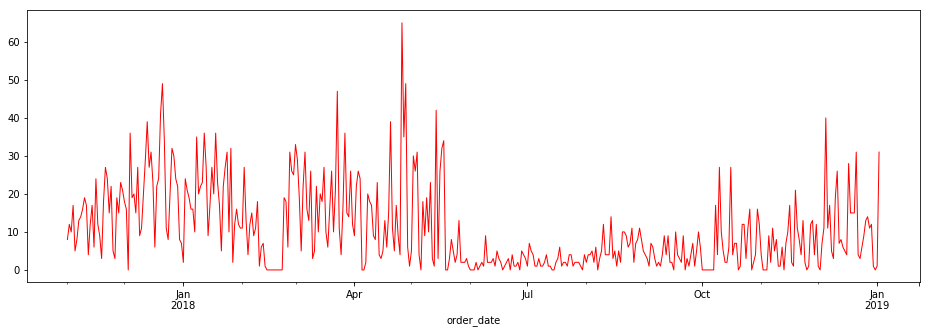

In [112]:
result_ts = result_ts['order_num'].resample('D').sum()
result_ts.plot(figsize = (16, 5), color = 'r', linewidth = 1)

In [113]:
result_ts.head()

order_date
2017-11-01     8
2017-11-02    12
2017-11-03    10
2017-11-04    17
2017-11-05     5
Freq: D, Name: order_num, dtype: int64

## 白噪声检验

In [114]:
from statsmodels.stats.diagnostic import acorr_ljungbox
def test_stochastic(ts,lag):
    p_value = acorr_ljungbox(ts, lags=lag) #lags可自定义
    return p_value
test_stochastic(result_ts,2)

(array([ 95.63249454, 145.00219227]), array([1.38317366e-22, 3.25967285e-32]))

## 平稳性检验

In [115]:
dftest = adfuller(result_ts)
output = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    output['Critical Value (%s)' % key] = value
output

Test Statistic                  -2.227951
p-value                          0.196258
#Lags Used                      18.000000
Number of Observations Used    409.000000
Critical Value (1%)             -3.446440
Critical Value (5%)             -2.868633
Critical Value (10%)            -2.570548
dtype: float64

In [116]:
result_ts_diff = result_ts.diff(1)
result_ts_diff.dropna(inplace = True)
dftest = adfuller(result_ts_diff)
output = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    output['Critical Value (%s)' % key] = value
output

Test Statistic                -6.832517e+00
p-value                        1.877944e-09
#Lags Used                     1.800000e+01
Number of Observations Used    4.080000e+02
Critical Value (1%)           -3.446480e+00
Critical Value (5%)           -2.868650e+00
Critical Value (10%)          -2.570557e+00
dtype: float64

In [74]:
result_ts_diff.head()

order_date
2017-11-02    0.405465
2017-11-03   -0.182322
2017-11-04    0.530628
2017-11-05   -1.223775
2017-11-06    0.470004
Freq: D, Name: order_num, dtype: float64

Text(0.5,1,'Partial Autocorrelation Function')

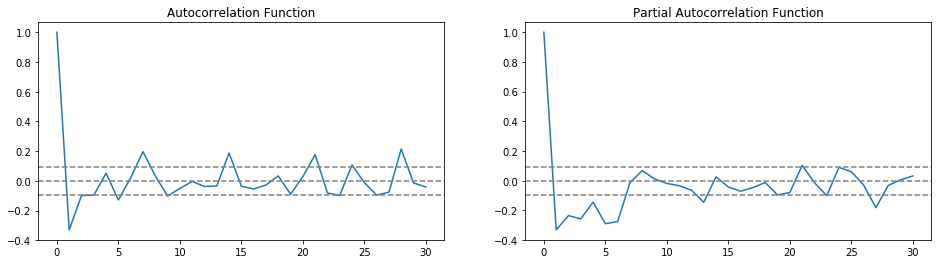

In [75]:
lag_acf = acf(result_ts_diff, nlags = 30)
lag_pacf = pacf(result_ts_diff, nlags = 30)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(result_ts_diff)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(result_ts_diff)), linestyle = '--', color = 'gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(result_ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(result_ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

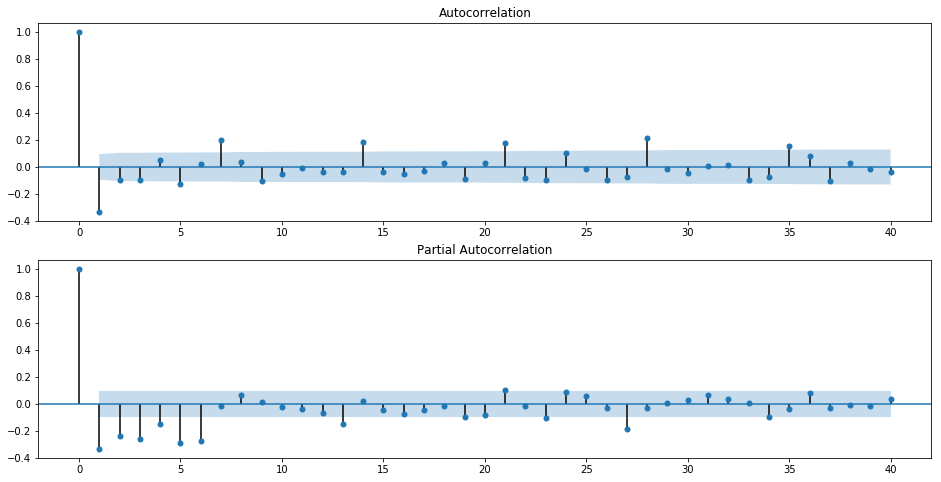

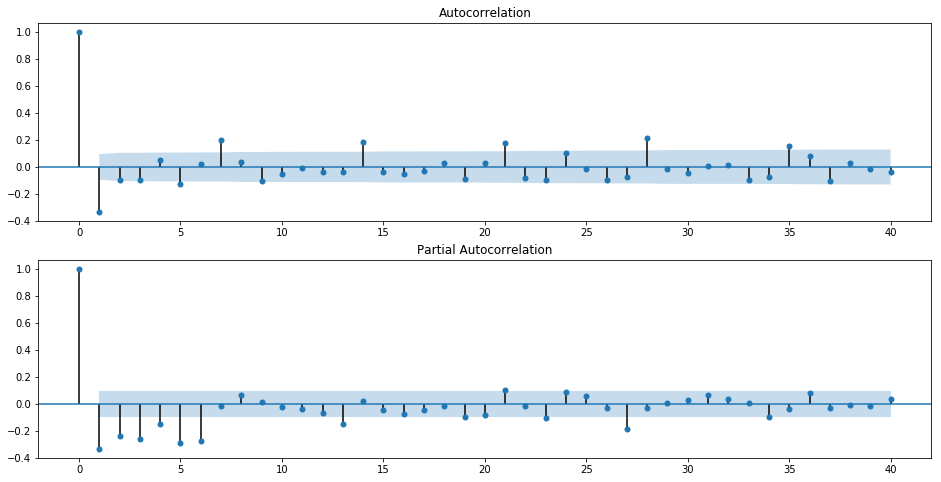

In [76]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(211)
plot_acf(result_ts_diff, lags = 40, ax = ax1)
ax2 = fig.add_subplot(212)
plot_pacf(result_ts_diff, lags = 40, ax = ax2)

In [117]:
result_ts_train = result_ts_diff[ : -(2*30)]
result_ts_test = result_ts_diff[-(2*30) : ]
result_ts_test.head(3).append(result_ts_test.tail(3))

order_date
2018-11-04     0.0
2018-11-05     9.0
2018-11-06    -7.0
2018-12-31    -1.0
2019-01-01     1.0
2019-01-02    30.0
Name: order_num, dtype: float64

In [118]:
import warnings
warnings.filterwarnings("ignore")
for p in range(0,6):
    for q in range(0,6):
        arma = ARMA(result_ts_train, order = (p, q))
        try:
            arma_model = arma.fit()
        except:
            continue
        print(p,q,arma_model.aic, arma_model.bic, arma_model.hqic)

0 0 2802.0085568543172 2809.8192805504264 2805.111999758397
0 1 2663.9623438763365 2675.6784294205004 2668.6175082324557
0 2 2654.9692787270897 2670.590726119308 2661.176164535249
1 0 2750.3325905650786 2762.0486761092425 2754.987754921198
1 1 2655.357447015839 2670.9788944080574 2661.5643328239985
1 2 2656.8918539231436 2676.4186631634166 2664.6504611833425
1 3 2658.5740242273914 2682.0061953157187 2667.8843529396304
1 4 2656.6739282788685 2684.0114612152506 2667.535978443147
1 5 2657.1402598937584 2688.383154678195 2669.554031510077
2 0 2728.2081554416827 2743.829602833901 2734.415041249842
2 1 2656.395006539874 2675.921815780147 2664.153613800073
2 2 2655.6621442601386 2679.094315348466 2664.9724729723775
2 3 2632.0064590628563 2659.3439919992384 2642.868509227135
2 4 2633.7775433489687 2665.020438133405 2646.1913149652873
2 5 2635.594064565139 2670.74232119763 2649.559557633497
3 0 2704.5746312374995 2724.1014404777725 2712.3332384976984
3 1 2654.5704336608646 2678.002604749192 266

In [119]:
arma_model = ARMA(result_ts_train, order = (5, 5)).fit()

In [120]:
arma_result = arma_model.predict()

Text(0.5,1,'TRAIN_RSME : 8.1135')

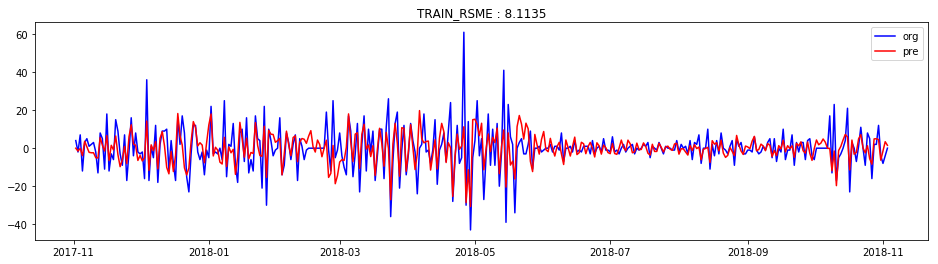

In [121]:
plt.plot(result_ts_train, label = 'org', color = 'b')
plt.plot(arma_result, label = 'pre', color = 'r')
plt.legend(loc = 'best')
plt.title("TRAIN_RSME : %.4f" % np.sqrt(np.sum((arma_result - result_ts_train) ** 2)/len(result_ts_train)))

In [123]:
result_ts_train_re = pd.Series(result_ts.iloc[0], index = [result_ts.index[0]]).append(result_ts_train).cumsum()
result_ts_train_re.head()

2017-11-01     8.0
2017-11-02    12.0
2017-11-03    10.0
2017-11-04    17.0
2017-11-05     5.0
dtype: float64

In [124]:
arma_result_re = pd.Series(result_ts.iloc[0], index = [result_ts.index[0]]).append(arma_result).cumsum()
arma_result_re.head()

2017-11-01    8.000000
2017-11-02    7.983608
2017-11-03    6.479954
2017-11-04    6.368332
2017-11-05    2.449018
dtype: float64

Text(0.5,1,'TRAIN_RSME : 31.8582')

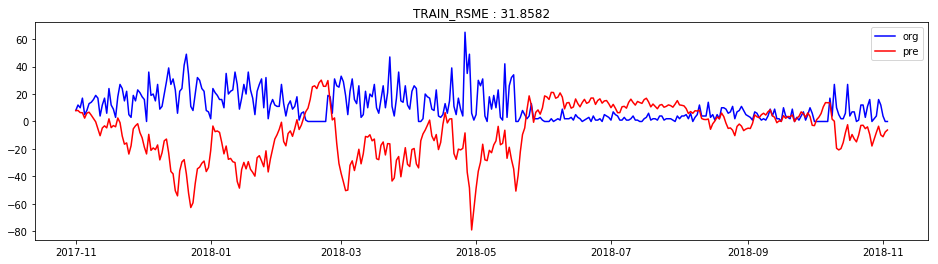

In [125]:
plt.plot(result_ts_train_re, label = 'org', color = 'b')
plt.plot(arma_result_re, label = 'pre', color = 'r')
plt.legend(loc = 'best')
plt.title("TRAIN_RSME : %.4f" % np.sqrt(np.sum((arma_result_re - result_ts_train_re) ** 2)/len(result_ts_train_re)))

In [126]:
test_result = arma_model.predict('2018-11-04', '2019-01-03', dynamic = True)

28.352862779978796

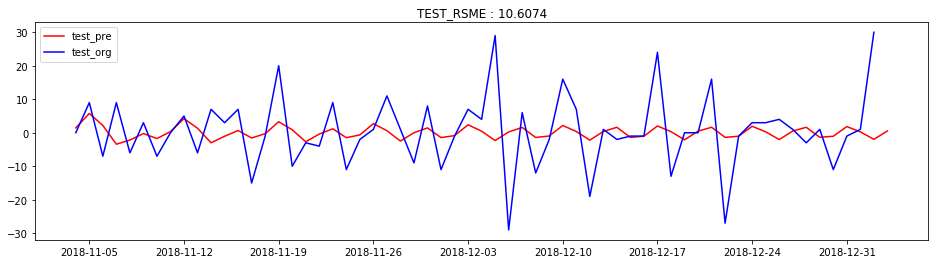

In [127]:
plt.plot(test_result, label = 'test_pre', color = 'r')
plt.plot(result_ts_test, label = 'test_org', color = 'b')
plt.legend(loc = 'best')
plt.title("TEST_RSME : %.4f" % np.sqrt(np.sum((result_ts_test - test_result) ** 2)/len(test_result)))
np.sum(result_ts_test-test_result)

In [ ]:
accurate=[]
for i in range(len(test_result)):
     accurate.append(min(test_result[i], result_ts_test[i])/max(test_result[i], result_ts_test[i]))
accurate = pd.DataFrame(accurate, index = test_result.index, columns = ['acc_rate'])
accurate.head()

## 差分还原

In [55]:
pd.Series(result_ts_test[-(2*30) : ][0], index = [result_ts[-(2*30) : ].index[0]])

2018-11-04    0
dtype: int64

In [72]:
test_result.head(10)

2018-11-04    1.450936
2018-11-05    5.748058
2018-11-06    2.179785
2018-11-07   -3.423411
2018-11-08   -2.172026
2018-11-09   -0.233676
2018-11-10   -1.727143
2018-11-11    0.349515
2018-11-12    4.212922
2018-11-13    1.352120
Freq: D, dtype: float64

In [ ]:
result_ts_test

Text(0.5,1,'RSME : 9.9715')

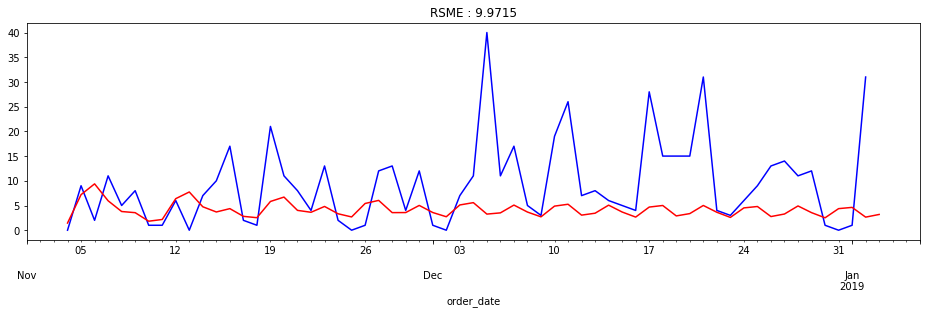

In [128]:
result_ts[-(2*30) : ].plot(label = 'test_org', color = 'b')
# test_result.plot()
# test_result_re = pd.Series(result_ts[-(2*30) : ][0], index = [result_ts[-(2*30) : ].index[0]]).append(test_result).cumsum()
test_result_re = test_result.cumsum()
test_result_re.plot(label = 'test_pre', color = 'r')
plt.title("RSME : %.4f" % np.sqrt(np.sum((test_result_re - result_ts[-(2*30) : ])**2)/len(result_ts[-(2*30) : ])))

## 一阶差分还原

In [59]:
time_series = pd.Series([2,4,3,5,6,7,4,5,6,3,2,4], index=pd.date_range(start='2000', periods=12, freq='a'))
time_series_diff = time_series.diff(1).dropna()
time_series_restored = pd.Series([time_series[0]], index=[time_series.index[0]]) .append(time_series_diff).cumsum()
# time_series_restored

## 多阶差分还原

In [66]:
time_series = pd.Series([2,4,3,5,6,7,4,5,6,3,2,4], index=pd.date_range(start='2000', periods=12, freq='a'))
time_series_diff = time_series
diff_times = 3
first_values = []
for i in range(1, diff_times+1):
    first_values.append(pd.Series([time_series_diff[0]],index=[time_series_diff.index[0]]))
    time_series_diff = time_series_diff.diff(1).dropna()

time_series_restored = time_series_diff
for first in reversed(first_values):
    time_series_restored = first.append(time_series_restored).cumsum()
# time_series_restored

2002-12-31   -3.0
dtype: float64


## SARIMAX

In [14]:
import itertools
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore")

p = q = range(0, 3)
d = (0, 1)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(result_ts_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
 
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3052.676172203688
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2875.025720164429
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:2726.433641180658
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2863.579625076016
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2605.6098526387814
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:2515.980424737768
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2795.116704488595
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2659.5824476949997
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:2568.135490186155
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2666.2753889498867
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2609.028448262008
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:2516.2076701091114
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:2636.999059704909
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:2574.8191987834907
ARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:2569.330332716798
ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:2545.7150878203797
ARIMA(0, 0, 0)x(2, 1, 1, 12)12 - AIC:2524.2711781651124
ARIMA(0, 0, 0)x(2, 1, 2, 12)12 - AIC:2518.2073384416585
AR

ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:2505.8601199992886
ARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:2415.1568067763583
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:2571.747488458138
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:2560.557630323467
ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:2470.9378364761606
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:2607.4179090300113
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:2507.7186564386357
ARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:2412.840861032129
ARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:2486.920210512203
ARIMA(1, 0, 2)x(2, 0, 1, 12)12 - AIC:2488.7473660698074
ARIMA(1, 0, 2)x(2, 0, 2, 12)12 - AIC:2466.042418734867
ARIMA(1, 0, 2)x(2, 1, 0, 12)12 - AIC:2472.308764469425
ARIMA(1, 0, 2)x(2, 1, 1, 12)12 - AIC:2429.3152897452833
ARIMA(1, 0, 2)x(2, 1, 2, 12)12 - AIC:2414.826188841857
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:2741.5784853667383
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:2656.675794965339
ARIMA(1, 1, 0)x(0, 0, 2, 12)12 - AIC:2560.7964305537357
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:2945.578713929745
A

ARIMA(2, 1, 1)x(1, 0, 2, 12)12 - AIC:2472.2333470915282
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:2598.4930743075834
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:2508.5963639087095
ARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:2414.5427517255307
ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:2471.4768515922947
ARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:2473.096548028684
ARIMA(2, 1, 1)x(2, 0, 2, 12)12 - AIC:2466.6345159633065
ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:2472.7506551650467
ARIMA(2, 1, 1)x(2, 1, 1, 12)12 - AIC:2416.460611029932
ARIMA(2, 1, 1)x(2, 1, 2, 12)12 - AIC:2416.3964143433477
ARIMA(2, 1, 2)x(0, 0, 0, 12)12 - AIC:2636.0858279589397
ARIMA(2, 1, 2)x(0, 0, 1, 12)12 - AIC:2550.489428615304
ARIMA(2, 1, 2)x(0, 0, 2, 12)12 - AIC:2466.02454386147
ARIMA(2, 1, 2)x(0, 1, 0, 12)12 - AIC:2819.301066798417
ARIMA(2, 1, 2)x(0, 1, 1, 12)12 - AIC:2500.814395999456
ARIMA(2, 1, 2)x(0, 1, 2, 12)12 - AIC:2405.161953158484
ARIMA(2, 1, 2)x(1, 0, 0, 12)12 - AIC:2556.36849851276
ARIMA(2, 1, 2)x(1, 0, 1, 12)12 - AIC:2550.5615554206847
AR

In [28]:
result_data = tmp.loc[tmp['dot'].isin(useful_dot_name['dot'])]
result_data.head()


,dot,order_date,order_num
order_date,,,
2017-11-01,宁海桃源点部,2017-11-01,61
2017-11-01,温州娄桥点部,2017-11-01,110
2017-11-01,寮步凫山点部,2017-11-01,16
2017-11-01,惠山玉祁点部,2017-11-01,31
2017-11-01,金陵光华门点部,2017-11-01,8


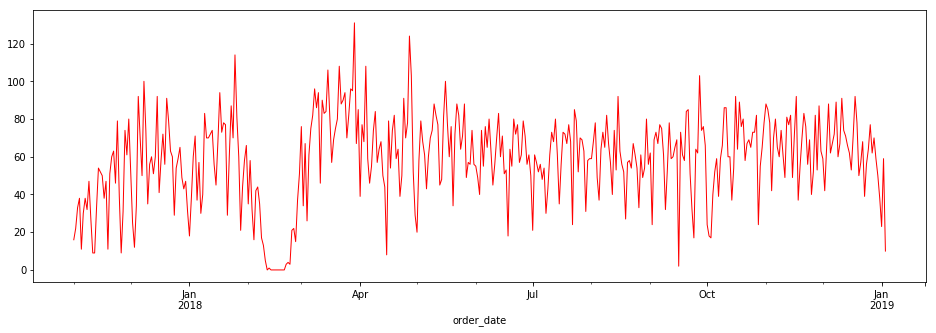

In [29]:
result_ts = result_data.loc[result_data['dot'] == '寮步凫山点部', ['order_num']]
# result_ts.plot(figsize = (16,5), color = 'r', linewidth=2)
result_ts = result_ts['order_num'].resample('D').sum()
result_ts.plot(figsize = (16, 5), color = 'r', linewidth = 1)


In [31]:
result_ts_train = result_ts[ : -(2*30)]
result_ts_test = result_ts[-(2*30) : ]
result_ts_test.head(3).append(result_ts_test.tail(3))

order_date
2018-11-05    70
2018-11-06    80
2018-11-07    65
2019-01-01    23
2019-01-02    59
2019-01-03    10
Name: order_num, dtype: int64

In [32]:
mod = sm.tsa.statespace.SARIMAX(result_ts_train,
                                            order=(2, 1, 2),
                                            seasonal_order=(1, 1, 2, 12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
 
results = mod.fit()
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.3489,0.641,-0.544,0.586,-1.606,0.908
ar.L2,0.2045,0.146,1.405,0.160,-0.081,0.490
ma.L1,-0.2241,0.653,-0.343,0.731,-1.504,1.056
ma.L2,-0.5053,0.521,-0.971,0.332,-1.525,0.515
ar.S.L12,-0.4585,0.347,-1.320,0.187,-1.139,0.222
ma.S.L12,-0.5443,472.511,-0.001,0.999,-926.649,925.561
ma.S.L24,-0.4557,215.348,-0.002,0.998,-422.530,421.619
sigma2,379.7930,1.79e+05,0.002,0.998,-3.51e+05,3.52e+05


Text(0.5,1,'TRAIN_RSME : 21.5271')

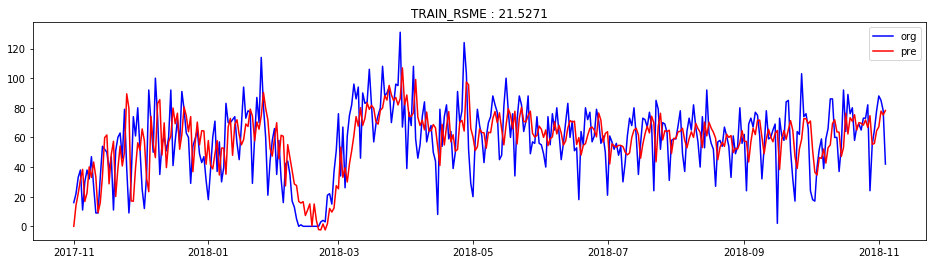

In [33]:
sarimax_result = results.predict()
plt.plot(result_ts_train, label = 'org', color = 'b')
plt.plot(sarimax_result, label = 'pre', color = 'r')
plt.legend(loc = 'best')
plt.title("TRAIN_RSME : %.4f" % np.sqrt(np.sum((sarimax_result - result_ts_train) ** 2)/len(result_ts_train)))

In [34]:
sarimax_result = results.predict('2018-11-04', '2019-01-03', dynamic = True)

Text(0.5,1,'TEST_RSME : 21.3160')

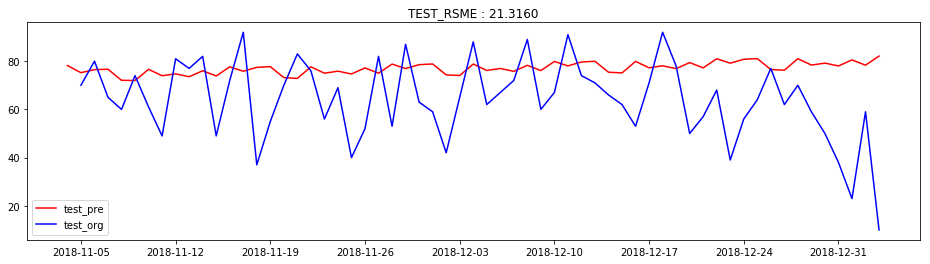

In [35]:
plt.plot(sarimax_result, label = 'test_pre', color = 'r')
plt.plot(result_ts_test, label = 'test_org', color = 'b')
plt.legend(loc = 'best')
plt.title("TEST_RSME : %.4f" % np.sqrt(np.sum((result_ts_test - sarimax_result) ** 2)/len(sarimax_result)))